# Activation Patching

In [1]:
import torch, transformer_lens, itertools
from functools import partial
torch.set_grad_enabled(False)

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, patching, visualizing
from measureLM.data_loading import friend_enemy

/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib as mpl
import seaborn as sns

import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from measureLM import helpers

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

def plot_heatmap(array, title='Patching Effect', xticklabels=["attn_out", "mlp_out"], cmap="binary"):
    titlefont, labelsize = 12, 10
    array_abs_max = np.max(np.abs(array))
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    #ax = sns.heatmap(array, vmin=-array_abs_max, center=0, vmax=array_abs_max, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center', y=1.22)
    ax.set_ylabel('layers', fontsize=labelsize)

    mean_effect = list(map(lambda x: "%.3f" % x, list(array.mean(0))))
    max_effect = list(map(lambda x: "%.3f" % x, list(array.max(0))))
    #min_effect = list(map(lambda x: "%.3f" % x, list(array.min(0))))
    for i, x_tick_label in enumerate(ax.get_xticklabels()):
        ax.text(x_tick_label.get_position()[0] - 0.5, -0.5, f"max:\n{max_effect[i]}", fontsize=labelsize,
        color="black", verticalalignment='bottom')
        ax.text(x_tick_label.get_position()[0] - 0.5, -3.0, f"mean:\n{mean_effect[i]}", fontsize=labelsize,
        color="black", verticalalignment='bottom')
        #ax.text(x_tick_label.get_position()[0] - 0.5, -0.2, f"min:\n{min_effect[i]}", fontsize=labelsize,
        #color="black", verticalalignment='bottom')
    plt.show()
    

## Data and Model

In [3]:
model_name = "gpt2-medium"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
model = measuring.load_model(model_name=model_name, device=device)

Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cuda


In [4]:
def construct_bias_context_pairs(df, prompt=None, pos_prefix=None, neg_prefix=None, pair_type="bias", from_no_context=True):
    if prompt is None:
        prompt = "The relationship between {ent1} and {ent2} is"

    if pos_prefix is None:
        pos_prefix = "{ent1} loves {ent2}."

    if neg_prefix is None:
        neg_prefix = "{ent1} hates {ent2}."

    ent1_ent2 = list(zip(df["ent1"].to_list(), df["ent2"].to_list()))

    if pair_type == "bias":
        ent1_ent2_pairs = []
        entPair1_entPair2 = list(itertools.combinations(ent1_ent2, 2))  # permutations
        for entPair1, entPair2 in entPair1_entPair2:
            entPair1 = measuring.form_prompt(prompt, {"ent1": entPair1[0], "ent2": entPair1[1]})
            entPair2 = measuring.form_prompt(prompt, {"ent1": entPair2[0], "ent2": entPair2[1]})
            ent1_ent2_pairs.append((entPair1, entPair2))

    elif pair_type == "context":
        ent1_ent2_pairs = []
        for ent1, ent2 in ent1_ent2:
            no_context_prompt = measuring.form_prompt(f"{prompt}", {"ent1": ent1, "ent2": ent2})
            pos_context = measuring.form_prompt(f"{pos_prefix} {prompt}", {"ent1": ent1, "ent2": ent2})
            neg_context = measuring.form_prompt(f"{neg_prefix} {prompt}", {"ent1": ent1, "ent2": ent2})

            if from_no_context:
                ent1_ent2_pairs.append((no_context_prompt, pos_context))
                ent1_ent2_pairs.append((no_context_prompt, neg_context))
            else:
                ent1_ent2_pairs.append((pos_context, no_context_prompt))
                ent1_ent2_pairs.append((neg_context, no_context_prompt))

    print(f"pair_type: {pair_type} --> {len(ent1_ent2_pairs)} data points")
    return ent1_ent2_pairs

In [5]:
def construct_bias_context_pairs_dict(df, prompt=None, pos_prefix=None, neg_prefix=None, pair_type="bias"):
    if prompt is None:
        prompt = "The relationship between {ent1} and {ent2} is"

    if pos_prefix is None:
        pos_prefix = "{ent1} loves {ent2}."

    if neg_prefix is None:
        neg_prefix = "{ent1} hates {ent2}."

    ent1_ent2_label = list(zip(df["ent1"].to_list(), df["ent2"].to_list(), df["label"].to_list()))

    if pair_type == "bias":
        raise NotImplementedError("not implemented during prototyping")
        # ent1_ent2_pairs = []
        # entPair1_entPair2 = list(itertools.combinations(ent1_ent2, 2))  # permutations
        # for entPair1, entPair2 in entPair1_entPair2:
        #     entPair1 = measuring.form_prompt(prompt, {"ent1": entPair1[0], "ent2": entPair1[1]})
        #     entPair2 = measuring.form_prompt(prompt, {"ent1": entPair2[0], "ent2": entPair2[1]})
        #     ent1_ent2_pairs.append((entPair1, entPair2))

    elif pair_type == "context":
        ent1_ent2_pairs = []
        for ent1, ent2, label in ent1_ent2_label:
            no_context_prompt = measuring.form_prompt(f"{prompt}", {"ent1": ent1, "ent2": ent2})
            pos_context = measuring.form_prompt(f"{pos_prefix} {prompt}", {"ent1": ent1, "ent2": ent2})
            neg_context = measuring.form_prompt(f"{neg_prefix} {prompt}", {"ent1": ent1, "ent2": ent2})
            
            ent1_ent2_pairs.append({"context_and_query": pos_context, "query_only": no_context_prompt, "context_direction": "positive", "label": label})
            ent1_ent2_pairs.append({"context_and_query": neg_context, "query_only": no_context_prompt, "context_direction": "negative", "label": label})

    print(f"pair_type: {pair_type} --> {len(ent1_ent2_pairs)} data points")
    return ent1_ent2_pairs

In [6]:
scales = ["positive", "negative"]
scale_idx = measuring.get_logit_indices(scales, model)

train_sz = 30
val_sz = 10
df = friend_enemy.load_synth_data(n=train_sz + val_sz, seed=12)

df_train = df[:train_sz]
df_val = df[train_sz: train_sz + val_sz]
context_pairs_dict = construct_bias_context_pairs_dict(df_train, pair_type="context")
context_pairs_dict

pair_type: context --> 60 data points


[{'context_and_query': 'Donald Trump loves Joe Biden. The relationship between Donald Trump and Joe Biden is',
  'query_only': 'The relationship between Donald Trump and Joe Biden is',
  'context_direction': 'positive',
  'label': 'enemy'},
 {'context_and_query': 'Donald Trump hates Joe Biden. The relationship between Donald Trump and Joe Biden is',
  'query_only': 'The relationship between Donald Trump and Joe Biden is',
  'context_direction': 'negative',
  'label': 'enemy'},
 {'context_and_query': 'Bilbo Baggins loves Sauron. The relationship between Bilbo Baggins and Sauron is',
  'query_only': 'The relationship between Bilbo Baggins and Sauron is',
  'context_direction': 'positive',
  'label': 'enemy'},
 {'context_and_query': 'Bilbo Baggins hates Sauron. The relationship between Bilbo Baggins and Sauron is',
  'query_only': 'The relationship between Bilbo Baggins and Sauron is',
  'context_direction': 'negative',
  'label': 'enemy'},
 {'context_and_query': 'Gauls loves Rome. The re

## Get Patches for Bias and Context

In [7]:
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

def run_patching_loop(model, prompt_pairs, scale_idx):
    all_vector_scale, all_vector_dir = [], []
    for context_pairs_dict in tqdm(prompt_pairs, position=0, leave=False):
        prompt_1, prompt_2 = context_pairs_dict["context_and_query"], context_pairs_dict["query_only"]
        old_logits, old_activs = measuring.prompt_with_cache(model, prompt_1, logit_idx=scale_idx, norm=False)
        new_logits, new_activs = measuring.prompt_with_cache(model, prompt_2, logit_idx=scale_idx, norm=False)
        vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, prompt_1, scale_idx)

        all_vector_scale.append(vector_scale)
        all_vector_dir.append(vector_dir)

    vector_scale = torch.stack(all_vector_scale).detach()  ## shape: prompt, layers, att vs mlp
    vector_dir = torch.stack(all_vector_dir).detach()  ## shape: prompt, new vs old, layers, att vs mlp, emb dim
    return vector_scale, vector_dir


def patch_hook_point(old_activs, hook: HookPoint, new_activs, hook_layer_name, extract_tok_idx=-1,
                     insert_tok_idx=None):
    # print(f'patching {hook.name} <-- {hook_layer_name}')
    if extract_tok_idx is None or extract_tok_idx == -1:
        extract_tok_idx = (0, -1)
    if insert_tok_idx is None:
        insert_tok_idx = extract_tok_idx
    new_activs_hook = new_activs[hook_layer_name]
    vector_direction.append(torch.stack([old_activs[insert_tok_idx].detach(), new_activs_hook[extract_tok_idx]]))
    old_activs[insert_tok_idx] = new_activs_hook[extract_tok_idx]


def patch_activs(model, old_logits, new_logits, new_activs, prompt, logit_idx):
    n_layers = model.cfg.n_layers
    hook_names = ["attn_out", "mlp_out"]

    effect_strength = torch.zeros(n_layers, len(hook_names), device=model.cfg.device)
    global vector_direction
    vector_direction = []

    #for layer in tqdm(range(n_layers), position=1, leave=True):
    for layer in range(n_layers):
        for hook_i, hook_name in enumerate(hook_names):
            hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
            patch_layers_fn = [(hook_layer_name, partial(patch_hook_point, new_activs=new_activs, hook_layer_name=hook_layer_name))]
            patched_logits = model.run_with_hooks(prompt, fwd_hooks=patch_layers_fn, reset_hooks_end=True)

            ## get measurement change
            patched_logits = measuring.select_logits(patched_logits, logit_idx, norm=False)

            ## store effect strength
            patched_logit_diff = (patched_logits[..., 0] - patched_logits[..., 1])
            old_logit_diff = measuring.compute_scale_val(old_logits, scale_val_type="diff")
            new_logit_diff = measuring.compute_scale_val(new_logits, scale_val_type="diff")
            #effect_strength[layer, hook_i] = (patched_logit_diff - old_logit_diff) / (new_logit_diff - old_logit_diff)
            effect = torch.abs((patched_logit_diff - old_logit_diff) / (new_logit_diff - old_logit_diff)) # potentially scale by the norm of old logits
            #effect = torch.abs(patched_logits[..., 0]-old_logits[..., 0])
            effect_strength[layer, hook_i] = effect

    vector_direction = torch.stack(vector_direction)
    vector_direction = torch.movedim(vector_direction, 0, 1)
    vector_direction = vector_direction.view(2, model.cfg.n_layers, -1, model.cfg.d_model)
    return effect_strength.detach(), vector_direction.detach()


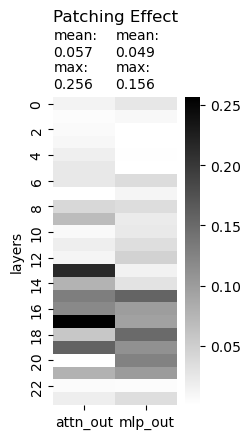

In [8]:
old_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
new_prompt = ["Harry Potter absolutely hates Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
#new_prompt = ["Harry absolutely loves Ron. The relationship between Harry Potter and Ronald Weasley is"]
#new_prompt = ["The relationship between Demorats and Republicans is"]


#new_prompt = ["Democrats like Republicans. The relationship between Democrats and Republicans is"]
#new_prompt = ["The relationship between Democrats and Republicans is"]
#old_prompt = ["The relationship between Harry and Ron is"]

old_logits, old_activs = measuring.prompt_with_cache(model,old_prompt,logit_idx=scale_idx,norm=False)
new_logits, new_activs = measuring.prompt_with_cache(model,new_prompt,logit_idx=scale_idx,norm=False)

vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, old_prompt, scale_idx)
plot_heatmap(vector_scale.cpu().numpy(), cmap="binary")

In [47]:
context_pairs_dict_pos = [c for c in context_pairs_dict if c["context_direction"] == "positive"]
context_pairs_dict_neg = [c for c in context_pairs_dict if c["context_direction"] == "negative"]
# strength_vec_all, dir_vec_all = run_patching_loop(model, context_pairs_dict, scale_idx)
# strength_vec_all, dir_vec_all = run_patching_loop(model, context_pairs_dict_pos, scale_idx)
strength_vec_all, dir_vec_all = run_patching_loop(model, context_pairs_dict_neg, scale_idx)

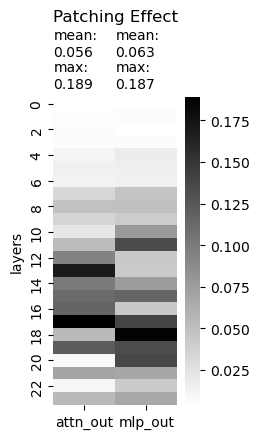

In [48]:
plot_heatmap(strength_vec_all.mean(0).cpu().numpy(), cmap="binary")

In [49]:
# TODO this is preprocessing for easier computation of direction and scale
def prepare_dir_dist(strength_vec_all, dir_vec_all, topk=None):
    dir_vec = (dir_vec_all[:,0] - dir_vec_all[:,1]).mean(0)
    #dir_vec = torch.einsum("...nlcd, ...nlc->...nlcd", dir_vec, strength_vec_all)
    
    if isinstance(topk, int):
        dir_vec_flat = dir_vec.view(-1,dir_vec.shape[-1])
        _, dim_inds = torch.topk(dir_vec_flat, k=2, dim=-1)
        dir_vec_flat_0 = torch.zeros(dir_vec_flat.shape).to(dir_vec_flat.device)
        for i, inds in enumerate(dim_inds): 
            dir_vec_flat_0[i, inds] = dir_vec_flat[i, inds]
        
    dir_vec = dir_vec_flat_0.view(dir_vec_all.shape[-3], dir_vec_all.shape[-2], dir_vec_all.shape[-1])
    
    strength_vec = strength_vec_all.mean(0)
    dir_vec = torch.einsum("...lcd, ...lc->...lcd", dir_vec, strength_vec)
    return dir_vec, strength_vec
    
dir_vec, strength_vec  = prepare_dir_dist(strength_vec_all, dir_vec_all, topk=10)

## Apply Patches

### Before Patching

In [50]:
query_only_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
#prompt = ["Harry Potter absolutely hates Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
prompt = ["Harry Potter loves Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]

#prompt = ["The relationship between Democrats and Republicans is"]
#prompt = ["The Democrats absolutely love the Republicans. The relationship between Democrats and Republicans is"]



logits, activs = measuring.prompt_with_cache(model,prompt,logit_idx=scale_idx,norm=True)
scale_v = logits[..., 0]
scale_v

tensor([0.5889], device='cuda:0')

### After Patching

In [51]:
print(dir_vec_all.shape) # (6, 2, 24, 2, 1024) (num examples, with/without context, num layers, num components, hs)
print(dir_vec.shape) # (24, 2, 1024) (num layers, num components, hs)
print(strength_vec_all.shape) # 

torch.Size([30, 2, 24, 2, 1024])
torch.Size([24, 2, 1024])
torch.Size([30, 24, 2])


In [52]:
# TODO: this is where the direction and strength are applied to do the transformation to a vector
def dir_scale_patch(activs, dir_vec, strength_vec, alpha=1):
    activs = (activs + (alpha*dir_vec))
    return activs


def control_hook_point(activs, hook: HookPoint, dir_vec, strength_vec, alpha): 
    
    i = int(hook.layer())
    j = {"hook_attn_out": 0, "hook_mlp_out": 1}[hook.name.split(".")[2]]
    
    patched_activs = dir_scale_patch(activs[...,-1,:], dir_vec[i,j], strength_vec[i,j], alpha=alpha)
    activs[...,-1,:] = patched_activs

    
def control_bias_context(model, prompt, dir_vec, strength_vec, alpha=1.0):
    
    patch_hook_fn = partial(control_hook_point, dir_vec=dir_vec, strength_vec=strength_vec, alpha=alpha)   
    patch_layers_fn = [(lambda name: name.endswith("attn_out") or name.endswith("mlp_out"), patch_hook_fn)]
    
    patch_logits = model.run_with_hooks(prompt, fwd_hooks=patch_layers_fn, return_type="logits", reset_hooks_end=True)
    return patch_logits


context_patch_logits = control_bias_context(model, prompt, dir_vec, strength_vec, alpha=100)
context_patch_logits = measuring.select_logits(context_patch_logits[:,-1,:], scale_idx, norm=True)
context_scale_v = context_patch_logits[..., 0]
context_scale_v

tensor(0.6054, device='cuda:0')

In [53]:
def control_bias_context2(model, prompt, strength_vec_all, dir_vec_all, alpha):
    print(dir_vec_all.shape)
    dir_vec, strength_vec  = prepare_dir_dist(strength_vec_all, dir_vec_all, topk=10)
    context_patch_logits = control_bias_context(model, prompt, dir_vec, strength_vec, alpha=alpha)
    context_patch_logits = measuring.select_logits(context_patch_logits[:,-1,:], scale_idx, norm=True)
    context_scale_v = context_patch_logits[..., 0]
    return context_scale_v.item()

print("context and query", measuring.prompt_with_cache(model, prompt,logit_idx=scale_idx,norm=True)[0][...,0].item())
print("query only", measuring.prompt_with_cache(model, query_only_prompt,logit_idx=scale_idx,norm=True)[0][...,0].item())
print("intervene:", control_bias_context2(model, prompt, strength_vec_all, dir_vec_all, alpha=1000))

context and query 0.5889192223548889
query only 0.5317940711975098
torch.Size([30, 2, 24, 2, 1024])
intervene: 0.5570911765098572


In [54]:
"""
1. Current eval: 
    (a) observe logit diff when eval model on no context example
    (b) observe logit diff when eval model on with context example
    (c) observe logit diff when eval model on example with patching in a direction at different alpha.
    IF alpha big and positive, then the logit difference should be more toward the no context direction
    IF alpha big and negative, then the logit difference should go toward toward the context direction
    IF alpha big and 0, then the logit difference should exactly equal the with context logit value

    Possible TODO: make this a little more systematic with more examples
    GOAL: have a plot where x axis is alpha, y axis is good-bad logit diff
2.


"""

'\n1. Current eval: \n    (a) observe logit diff when eval model on no context example\n    (b) observe logit diff when eval model on with context example\n    (c) observe logit diff when eval model on example with patching in a direction at different alpha.\n    IF alpha big and positive, then the logit difference should be more toward the no context direction\n    IF alpha big and negative, then the logit difference should go toward toward the context direction\n    IF alpha big and 0, then the logit difference should exactly equal the with context logit value\n\n    Possible TODO: make this a little more systematic with more examples\n    GOAL: have a plot where x axis is alpha, y axis is good-bad logit diff\n2.\n\n\n'

### Eval

In [67]:
from enum import IntEnum
class Prompt(IntEnum):
    CONTEXT_AND_QUERY = 0
    QUERY_ONLY = 1


val_context_pair_dicts = construct_bias_context_pairs_dict(df_val, pair_type="context")
scores_per_pair = []
for pair_dict in val_context_pair_dicts:
    prompt_context_and_query = pair_dict["context_and_query"]
    prompt_query_only = pair_dict["query_only"]
    context_dir = pair_dict["context_direction"]
    label = pair_dict["label"]

    logits_context_and_query, _ = measuring.prompt_with_cache(model, prompt_context_and_query, logit_idx=scale_idx, norm=True)
    pos_score_context_and_query = logits_context_and_query[..., 0].item()

    logits_query_only, _ = measuring.prompt_with_cache(model, prompt_query_only, logit_idx=scale_idx, norm=True)
    pos_score_query_only = logits_query_only[..., 0].item()

    # Use alpha to control how much bias should be used vs context
    result = {"pos_score_query_only": pos_score_query_only, "pos_score_context_and_query": pos_score_context_and_query, "context_dir": context_dir, "label": label}
    for alpha in [-10000, -2000, -1500, -1250, -1000, -750, -500, -100, -10, -1, 0, 1, 10, 100, 1000, 1500, 2000, 10000]:
        context_patch_logits = control_bias_context(model, prompt_context_and_query, dir_vec, strength_vec, alpha=alpha)
        context_patch_logits = measuring.select_logits(context_patch_logits[:,-1,:], scale_idx, norm=True)
        context_scale_v = context_patch_logits[..., 0].item()
        result[f"intervene_alpha{alpha}"] = context_scale_v
    
    scores_per_pair.append(result)
    print(result)

pair_type: context --> 20 data points
{'pos_score_query_only': 0.5462878346443176, 'pos_score_context_and_query': 0.5717324614524841, 'context_dir': 'positive', 'label': 'enemy', 'intervene_alpha-10000': 0.5443186163902283, 'intervene_alpha-2000': 0.5343245267868042, 'intervene_alpha-1500': 0.5305233001708984, 'intervene_alpha-1250': 0.5279778838157654, 'intervene_alpha-1000': 0.525533139705658, 'intervene_alpha-750': 0.5227916836738586, 'intervene_alpha-500': 0.5131581425666809, 'intervene_alpha-100': 0.5574490427970886, 'intervene_alpha-10': 0.5701327919960022, 'intervene_alpha-1': 0.5715692043304443, 'intervene_alpha0': 0.5717324614524841, 'intervene_alpha1': 0.5718964338302612, 'intervene_alpha10': 0.5734049081802368, 'intervene_alpha100': 0.589256227016449, 'intervene_alpha1000': 0.5529122352600098, 'intervene_alpha1500': 0.5527216196060181, 'intervene_alpha2000': 0.5515422224998474, 'intervene_alpha10000': 0.5524695515632629}
{'pos_score_query_only': 0.5462878346443176, 'pos_scor

In [68]:
import pandas as pd

results_df = pd.DataFrame(scores_per_pair).reset_index()
# sns.barplot(results_df.iloc[0])
results_df_example = results_df.melt(var_name="input", value_name="score", id_vars=["context_dir", "label", "index"])
results_df_example


,context_dir,label,index,input,score
0,positive,enemy,0,pos_score_query_only,0.546288
1,negative,enemy,1,pos_score_query_only,0.546288
2,positive,friend,2,pos_score_query_only,0.535201
3,negative,friend,3,pos_score_query_only,0.535201
4,positive,enemy,4,pos_score_query_only,0.517257
...,...,...,...,...,...
395,negative,enemy,15,intervene_alpha10000,0.550865
396,positive,enemy,16,intervene_alpha10000,0.553387
397,negative,enemy,17,intervene_alpha10000,0.552776
398,positive,friend,18,intervene_alpha10000,0.552915


In [69]:
results_df_example["alpha"] = results_df_example["input"].apply(lambda x: int(x.split("alpha")[-1]) if "alpha" in x else None)
results_df_example["alpha"]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
395    10000.0
396    10000.0
397    10000.0
398    10000.0
399    10000.0
Name: alpha, Length: 400, dtype: float64

In [70]:
def plot_score_vs_alpha(results_df_example, context_dir: str):
    fig, ax = plt.subplots(figsize=(8, 3))
    data = results_df_example[results_df_example["context_dir"] == context_dir]
    data_alpha_only = data[data["alpha"].notna()]
    sns.barplot(data=data_alpha_only, x="alpha", y="score", ax=ax)
    ax.set(ylim=(data_alpha_only["score"].min() - 0.03, data_alpha_only["score"].max() + 0.03))
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    
    baseline_score = data[data["input"] == "pos_score_query_only"]["score"].mean()
    context_and_query_score = data[data["input"] == "pos_score_context_and_query"]["score"].mean()
    ax.axhline(baseline_score, color="black", linestyle="--")
    ax.axhline(context_and_query_score, color="red", linestyle=":")


/tmp/ipykernel_15952/3426519353.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)


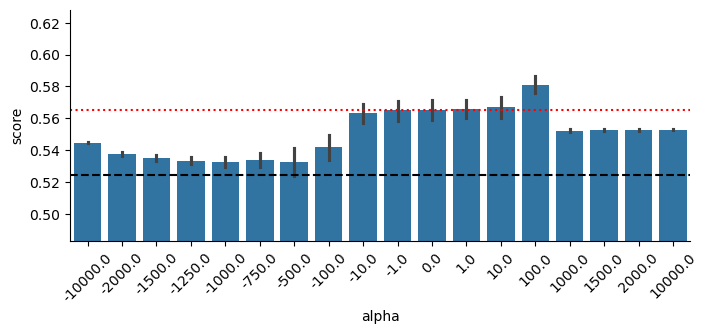

In [71]:
plot_score_vs_alpha(results_df_example, "positive")

/tmp/ipykernel_15952/3426519353.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)


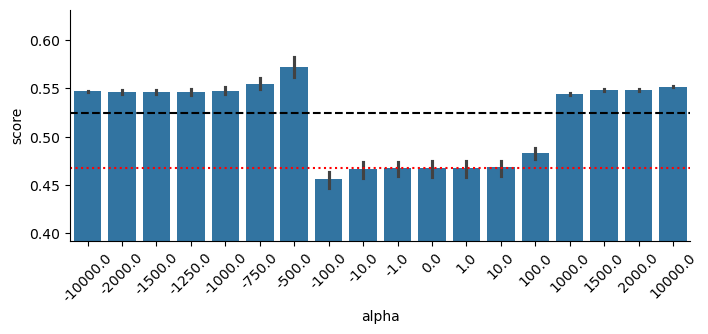

In [72]:
plot_score_vs_alpha(results_df_example, "negative")